In [1]:
import time
start_time=time.time()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lmfit
from scipy import interpolate
import pickle

from bfunc import bfunc00,bfunc01,bfunc02

Data load and region parameters

In [3]:
name = 'M8'

In [4]:
reg = 'Lagoon'

In [5]:
pickle_in = open('SFresults//' + name + '.pkl',"rb")
SFresults = pickle.load(pickle_in)

In [6]:
B = SFresults['b2']
r = SFresults['s']
s0 = SFresults['s0']   
m = SFresults['m'] 
sig2 = SFresults['sig2'] 
r0 = SFresults['r0'] 
noise = B.mean()*0.05

In [7]:
model02 = lmfit.Model(bfunc02)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [8]:
relative_uncertainty = 0.175
weights = 1.0 / (relative_uncertainty * B)
weights[r > r0] /= 2.0

In [9]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
#model02.set_param_hint("sig2", value=sig2, vary=False)
#model02.set_param_hint("s0", min=0.2)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        0      inf     True    
sig2        nan        0      inf     True    


In [10]:
result2 = model02.fit(
    B, 
    weights=weights,
    r = r, r0 = r0, m = m, s0 = s0, noise = noise, sig2=sig2,
)

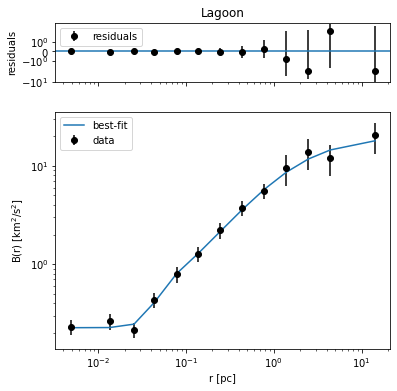

In [11]:
fig, _ = result2.plot( 'ko')
fig.axes[0].set(
    title=reg,
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
);

plt.savefig('Imgs//SF//' + reg + '.pdf', bbox_inches='tight')



In [12]:
CIresults = {'resultCI' : result2,
            'Rmax/r0' : r.max()/result2.params['r0'].value,
            'lT' : (r[3]/2**0.5)*((result2.params['r0'].value/r[3])**(result2.params['m'].value/2))
          }

In [13]:
f = open('CIresults//' + name +'.pkl',"wb")
pickle.dump(CIresults,f)
f.close()

In [14]:
print(result2.fit_report())

[[Model]]
    Model(bfunc02)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 13
    # variables        = 5
    chi-square         = 2.24630202
    reduced chi-square = 0.28078775
    Akaike info crit   = -12.8236325
    Bayesian info crit = -9.99888575
[[Variables]]
    r0:     1.78432769 +/- 0.57303689 (32.12%) (init = 1.090622)
    sig2:   9.72829014 +/- 1.84859398 (19.00%) (init = 7.526434)
    m:      1.11418630 +/- 0.08319679 (7.47%) (init = 1.3)
    s0:     0.02152442 +/- 0.00269322 (12.51%) (init = 0.002315989)
    noise:  0.22671292 +/- 0.01366231 (6.03%) (init = 0.2705701)
[[Correlations]] (unreported correlations are < 0.100)
    C(r0, sig2)  =  0.933
    C(r0, m)     = -0.863
    C(sig2, m)   = -0.663
    C(m, s0)     = -0.447
    C(s0, noise) =  0.368
    C(r0, s0)    =  0.321
    C(sig2, s0)  =  0.229


In [15]:
for p in result2.model.param_names:
    result2.params[p].stderr = result2.params[p].value * 0.1

In [16]:
result2.conf_interval()
print(result2.ci_report())

          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0   :  -1.25807  -0.89932  -0.50344   1.78433  +0.82582  +2.88618 +18.26222
 sig2 :  -5.49105  -3.54979  -1.80337   9.72829  +2.32809  +6.50023 +22.75310
 m    :  -0.34045  -0.18888  -0.08714   1.11419  +0.09218  +0.21471  +0.43137
 s0   :  -0.00987  -0.00553  -0.00250   0.02152  +0.00278  +0.00747  +0.01784
 noise:  -0.05912  -0.03219  -0.01440   0.22671  +0.01428  +0.03156  +0.05675


In [17]:
plt.style.use([
    "seaborn-poster",
])

In [18]:
plot_limits = {
    "s0": [0.0, 0.1],
    "m": [.5, .5],
    "r0": [0.1, 1.0],
    "noise": [0.0, 0.5],
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('M8')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "s0"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

In [19]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 46.050755977630615 seconds ---
